# Logistic regression example

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pystan

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})
figpath='../doc/fig/'

In [2]:
############################
############################
##    data generation     ##
############################
############################

# settings
np.random.seed(520)
N = 100 
true_beta = np.array([2.,3.])

# create data matrix
X = np.ones((N,2))
X[:,1] = -1.+1.5*np.random.randn(N)

# create response variable
eta = X.dot(true_beta)
true_p = 1./(1+np.exp(-eta))
Y = np.random.binomial(1,true_p,N)

Text(0.5, 1.0, 'Response $y$ and probability as function of $\\beta_1$')

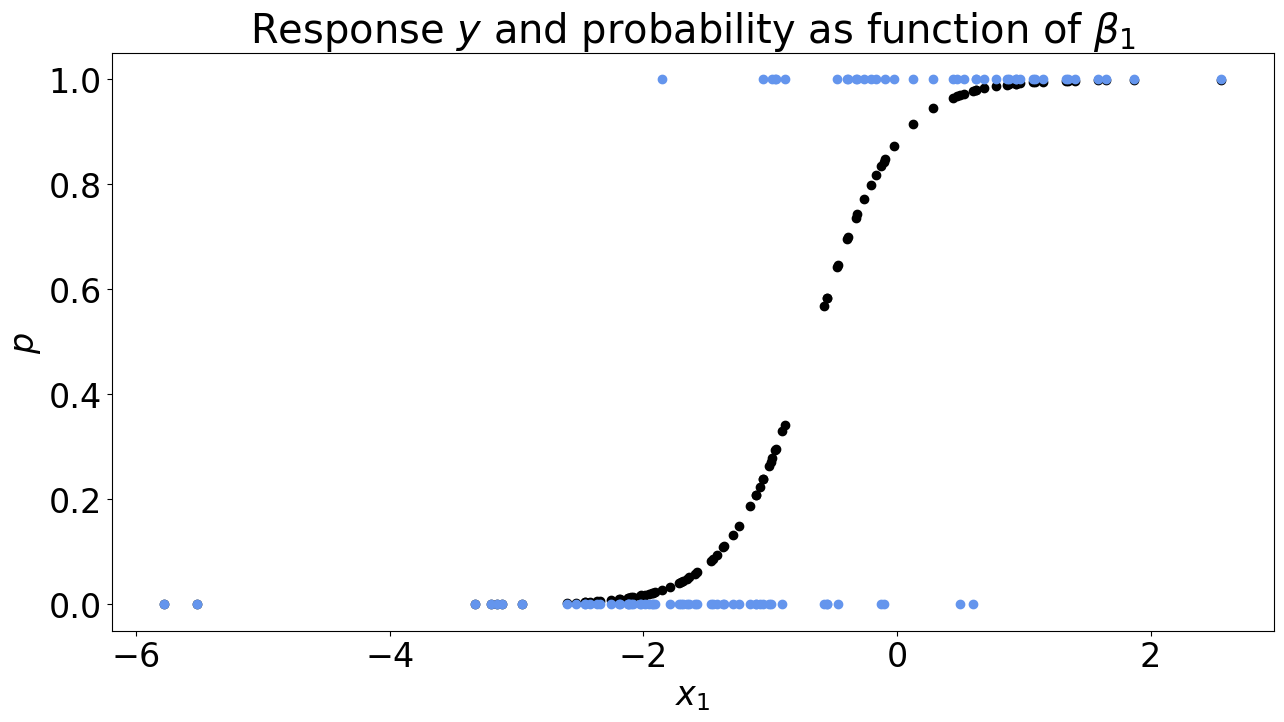

In [4]:
plt.scatter(X[:,1],true_p,c='black')
plt.scatter(X[:,1],Y,c='cornflowerblue')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$p$')
plt.title(r'Response $y$ and probability as function of $\beta_1$')

## Fit model with Stan

In [11]:
# model definition
stan_code = """
data {
  int<lower=0> n; // number of observations
  int y[n]; // responses
  vector[n] x1; // predictors
  real beta0; // intercept
}
parameters {
  real beta1;
}
model {
  beta1 ~ normal(0, 30);
  y ~ bernoulli_logit(beta0+beta1*x1);
}
"""

In [12]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_885816be3a6e229f8e2d0b5893720007 NOW.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/2

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:3

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/mcmc/hmc/nuts/base_nuts.hpp:114:17: note: in instantiation of member function 'stan::mcmc::base_nuts<anon_model_885816be3a6e229f8e2d0b5893720007_namespace::anon_model_885816be3a6e229f8e2d0b5893720007, stan::mcmc::dense_e_metric, stan::mcmc::expl_leapfrog, boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399>>>::build_tree' requested here
              = build_tree(this->depth_, z_propose,
                ^
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/services/sample/hmc_nuts_dense_e.hpp:79:11: note: in instantiation of member function 'stan::mcmc::base_nuts<anon_model_885816be3a6e229f8e2d0b5893720007_namespace::anon_model_885816be3a6e229f8e2d0b5893720007, stan::mcmc::dense_e_metric, stan::mcmc::expl_leapfrog, boost::random::a

164 warnings generated.
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:836:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/numeric/odeint.hpp:3

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:473:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

  return tcrossprod(static_cast<matrix_v>(M.transpose()));
                    ^
In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

In file included from /var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/pystan_yy7nqr1n/stanfit4anon_model_885816be3a6e229f8e2d0b5893720007_7199112193202303509.cpp:845:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/giankdiluvi/Library/Python/3.9/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/giankd

163 warnings generated.
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'
ld: warning: directory not found for option '-L/usr/local/opt/ruby/lib'


In [20]:
# run in stan
stan_data = {'n': N,
             'y': Y,
             'x1': X[:,1],
             'beta0': true_beta[0]}
fit = model.sampling(data=stan_data, iter=1000, chains=1)


Gradient evaluation took 2.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.008162 seconds (Warm-up)
               0.007081 seconds (Sampling)
               0.015243 seconds (Total)



In [22]:
# summary statistics
print(fit.stansummary(pars=['beta1']))
samples = fit.extract()

Inference for Stan model: anon_model_885816be3a6e229f8e2d0b5893720007.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   2.89    0.03   0.36   2.21   2.64   2.85   3.12   3.69    179    1.0

Samples were drawn using NUTS at Wed Apr 19 16:38:03 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


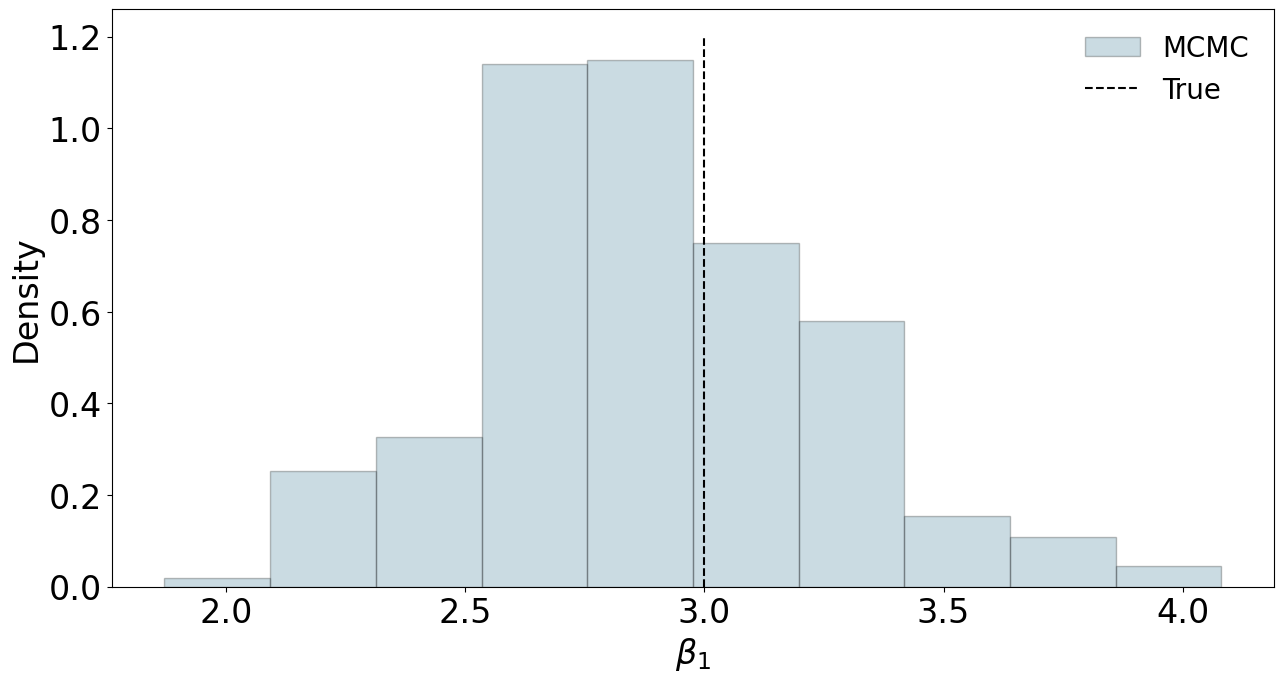

In [25]:
plt.hist(samples['beta1'], color='#2D718EFF',ec='black',alpha=0.25,label='MCMC',density=True)
plt.vlines(true_beta[1],0,1.2,color='black',ls='dashed',label='True')
plt.xlabel(r'$\beta_1$')
plt.ylabel('Density')
leg = plt.legend(fontsize='small',frameon=False)
#for lh in leg.legendHandles: lh.set_alpha(1)
#plt.savefig(fig_path+'logreg_mcmc_scatter.pdf', dpi=300, bbox_inches='tight')

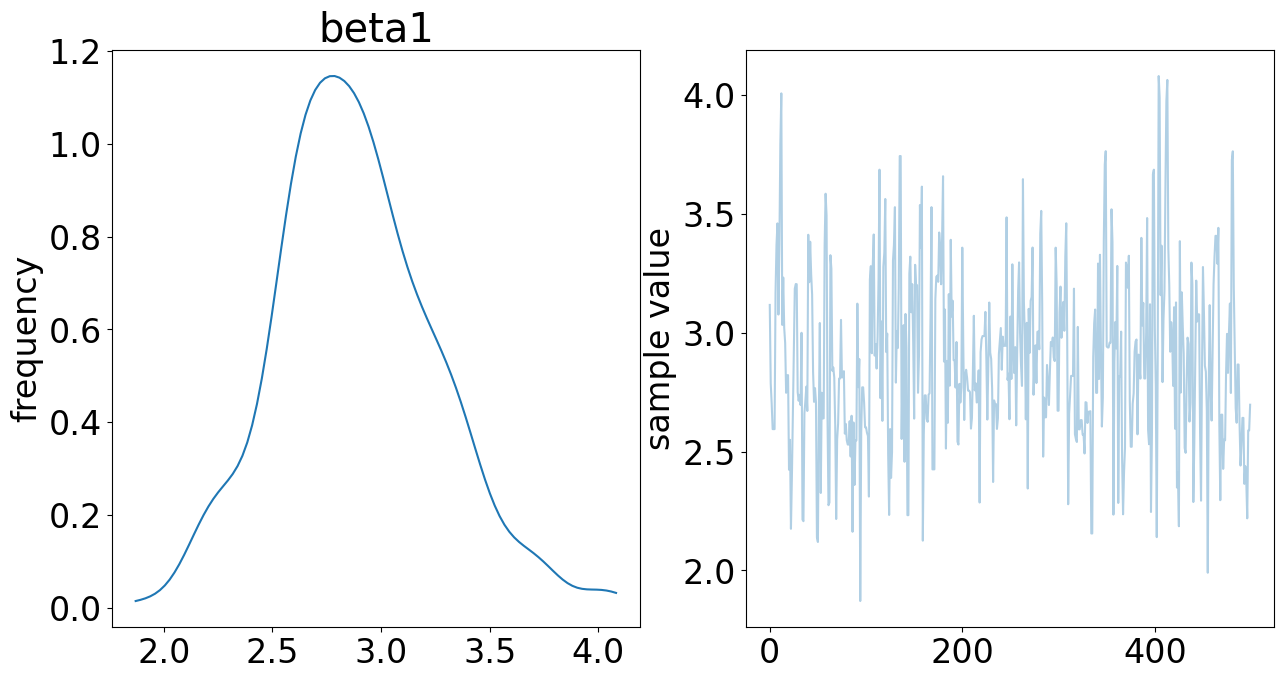

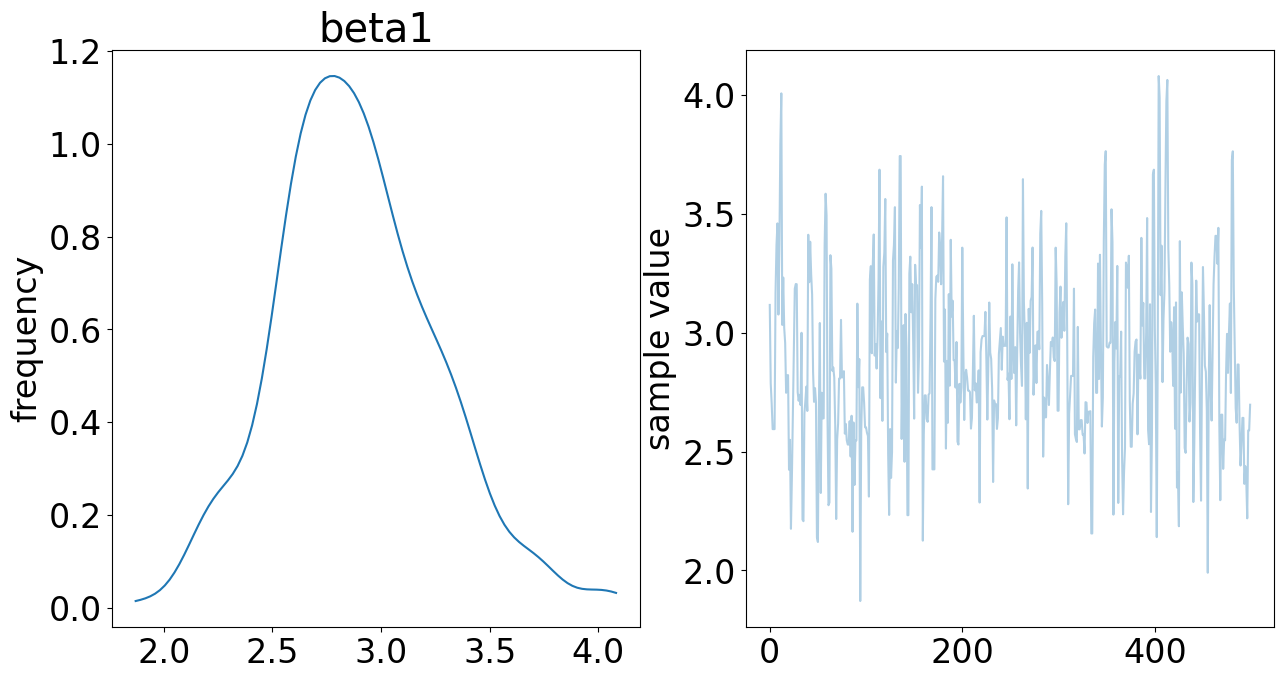

In [26]:
fit.plot()